### Training an AI agent to play Pong using DQN (based on the DeepMind Paper Human-level control through deep reinforcement learning)

In [2]:
# run only once!
#!pip install "numpy<2.0" tensorflow gymnasium[atari] ale-py opencv-python matplotlib
#!pip uninstall -y tensorflow
#!pip install tensorflow-macos
#!pip install --upgrade tensorflow-metal
#!pip uninstall -y tensorflow-macos
#!pip install --upgrade tensorflow

In [2]:
import random
import collections
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import gymnasium as gym
import ale_py
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from ale_py.vector_env import AtariVectorEnv
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation
from gymnasium.wrappers import RecordVideo

from IPython.display import display, clear_output



#### Visualising the game

In [1]:
gym.register_envs(ale_py)

# Create a Pong environment with visual rendering for demo
env_vis = gym.make("ALE/Pong-v5", render_mode="rgb_array")

obs, info = env_vis.reset(seed=42)

plt.figure(figsize=(6, 6))
for step in range(100):
    frame = env_vis.render()  # RGB frame from environment

    plt.imshow(frame)
    plt.axis("off")
    display(plt.gcf())
    clear_output(wait=True)

    # Random action just to see movement
    action = env_vis.action_space.sample()
    obs, reward, terminated, truncated, info = env_vis.step(action)

    if terminated or truncated:
        obs, info = env_vis.reset()

env_vis.close()
plt.close()

NameError: name 'gym' is not defined

#### Pre-processsing data, build experience replay, Q-network and epsilon-greedy policy

In [17]:
# ---------- Preprocessing: RGB frame -> (84,84) grayscale ----------
def preprocess(frame):
    # frame: (210,160,3) RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    # frame = frame.astype(np.float32) / 255.0
    # return frame  # (84,84), float32 in [0,1]
    return frame.astype(np.uint8) # Store frame as unit8


# ---------- Replay Buffer ----------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert frame from unit8 to float32
        states = np.array(states, dtype=np.uint8).astype(np.float32) / 255.0
        next_states = np.array(next_states, dtype=np.uint8).astype(np.float32) / 255.0
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int32),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)


# ---------- Q-network (DQN) ----------
def build_q_network(num_actions):
    model = keras.Sequential([
        # layers.Input(shape=(4, 84, 84)),  # channels-first (C,H,W)

        #layers.Conv2D(32, 8, strides=4, activation="relu", data_format="channels_first"),
        #layers.Conv2D(64, 4, strides=2, activation="relu", data_format="channels_first"),
        #layers.Conv2D(64, 3, strides=1, activation="relu", data_format="channels_first"),

        layers.Input(shape=(84, 84, 4)),  # channels-last (H,W,C)
        layers.Conv2D(32, 8, strides=4, activation="relu"),
        layers.Conv2D(64, 4, strides=2, activation="relu"),
        layers.Conv2D(64, 3, strides=1, activation="relu"),

        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_actions)  # Q-values for each action
    ])
    return model


# ---------- ε-greedy schedule ----------
def epsilon_by_step(step, eps_min=0.1, decay_steps=150_000):
    if step >= decay_steps:
        return eps_min
    frac = step / decay_steps
    return 1.0 + frac * (eps_min - 1.0)  # linear decay from 1.0 -> eps_min


def select_action(model, state, epsilon, num_actions):
    # state: (4,84,84)
    if random.random() < epsilon:
        return random.randrange(num_actions)
    state_tf = tf.convert_to_tensor(state[None, ...], dtype=tf.float32)  # (1,4,84,84)
    # state_tf = tf.expand_dims(tf.convert_to_tensor(state, tf.float32), 0) # (1,84,84,4)
    q_values = model(state_tf, training=False)[0]  # (num_actions,)
    return int(tf.argmax(q_values).numpy())

class ChannelsLast(gym.ObservationWrapper):
    def observation(self, obs):
        # (4,84,84) -> (84,84,4)
        # obs = np.asarray(obs)           # convert LazyFrames -> ndarray
        return np.transpose(obs, (1, 2, 0))

def initialise_environment(env_name = "ALE/Pong-v5", record_video = False, video_name_prefix=""):
    
    if record_video:
        # Create Pong env for recording
        env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
        env = RecordVideo(
            env.unwrapped,
            video_folder="./videos",
            episode_trigger=lambda e: True,
            name_prefix=video_name_prefix
        )
    else:    
        # Create Pong env for training (no rendering here)
        env = gym.make(env_name, render_mode=None, frameskip=1)
    
    env = AtariPreprocessing(env, noop_max=10, frame_skip=4, screen_size=84, grayscale_obs=True, scale_obs=False)
    env = FrameStackObservation(env, stack_size=4)
    env = ChannelsLast(env)
    return env

def record_episode(env, state, q_net):
    done = False
    total_reward = 0
    
    while not done:
        # Greedy policy from trained agent
        action = select_action(q_net, state, epsilon=0.0, num_actions=num_actions)
    
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        
    return total_reward
    



#### Train agent

In [22]:
start_time = time.time()

# Create an environment for training
env = initialise_environment(env_name = "ALE/Pong-v5")
state, info = env.reset(seed=42)
num_actions = env.action_space.n

# Build networks and components
q_net = build_q_network(num_actions)
target_net = build_q_network(num_actions)
target_net.set_weights(q_net.get_weights())

optimizer = keras.optimizers.Adam(learning_rate=1e-4)

huber = tf.keras.losses.Huber()

@tf.function
def train_step(states_b, actions_b, rewards_b, next_states_b, dones_b):
    states_tf      = tf.convert_to_tensor(states_b, dtype=tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states_b, dtype=tf.float32)
    actions_tf     = tf.convert_to_tensor(actions_b, dtype=tf.int32)
    rewards_tf     = tf.convert_to_tensor(rewards_b, dtype=tf.float32)
    dones_tf       = tf.convert_to_tensor(dones_b, dtype=tf.float32)

    # ---- DQN update ----
    with tf.GradientTape() as tape:
        q_values = q_net(states_tf, training=True)
        action_one_hot = tf.one_hot(actions_tf, num_actions)
        q_s_a = tf.reduce_sum(q_values * action_one_hot, axis=1)

        target_q_values = target_net(next_states_tf, training=False)
        max_next_q = tf.reduce_max(target_q_values, axis=1)

        # targets = rewards_tf + GAMMA * (1.0 - dones_tf) * max_next_q
        targets = tf.stop_gradient(rewards_tf + GAMMA * (1.0 - dones_tf) * max_next_q)
        # loss = tf.reduce_mean(tf.square(q_s_a - targets))
        loss = tf.reduce_mean(huber(targets, q_s_a))

    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_net.trainable_variables))    
    
    return loss    
    
replay_buffer = ReplayBuffer(capacity=150_000)

GAMMA = 0.99
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = 1_000   # steps
WARMUP_STEPS = 10_000        # collect some data before learning
TOTAL_STEPS = 1_000_001        # increase later for better results

# Save the model after this many steps
save_model_steps = {0, 50_000, 100_000, 250_000, 500_000, 750_000, 1_000_000}

episode_reward = 0.0
episode_rewards = []
episode_end_steps = []

step_time = 0.0
sample_time = 0.0
dqn_update_time = 0.0


for step in range(TOTAL_STEPS):
    # ---- ε-greedy action selection ----
    epsilon = epsilon_by_step(step)
    action = select_action(q_net, state, epsilon, num_actions)

    # ---- env step ----
    t0 = time.time()
    
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # next_frame = next_state[-1]  # get the last stacked frame
    # next_frame = next_state[:, :, -1]   # shape (84,84)

    # ---- store transition ----
    replay_buffer.push(state, action, float(reward), next_state, float(done))
    state = next_state
    episode_reward += reward

    step_time += time.time() - t0

    # ---- handle episode end ----
    if done:
        state, info = env.reset()
            
        episode_rewards.append(episode_reward)
        episode_end_steps.append(step)
        print(f"[Step {step}] Episode finished, reward = {episode_reward}")
        episode_reward = 0.0

    # ---- save the model at certain check point ----
    if step in save_model_steps:            
        q_net.save(f"pong_dqn fix8 ({step} steps).keras")

    # ---- warmup: no learning yet ----
    if step < WARMUP_STEPS or len(replay_buffer) < BATCH_SIZE:
        continue

    # ---- sample minibatch ----
    t0 = time.time()
    states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(BATCH_SIZE)
    sample_time += time.time() - t0

    t0 = time.time()

    # tf.config.run_functions_eagerly(False)
    loss = train_step(states_b, actions_b, rewards_b, next_states_b, dones_b)
    
    """
    states_tf      = tf.convert_to_tensor(states_b, dtype=tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states_b, dtype=tf.float32)
    actions_tf     = tf.convert_to_tensor(actions_b, dtype=tf.int32)
    rewards_tf     = tf.convert_to_tensor(rewards_b, dtype=tf.float32)
    dones_tf       = tf.convert_to_tensor(dones_b, dtype=tf.float32)

    # ---- DQN update ----
    with tf.GradientTape() as tape:
        q_values = q_net(states_tf, training=True)
        action_one_hot = tf.one_hot(actions_tf, num_actions)
        q_s_a = tf.reduce_sum(q_values * action_one_hot, axis=1)

        target_q_values = target_net(next_states_tf, training=False)
        max_next_q = tf.reduce_max(target_q_values, axis=1)

        # targets = rewards_tf + GAMMA * (1.0 - dones_tf) * max_next_q
        targets = tf.stop_gradient(rewards_tf + GAMMA * (1.0 - dones_tf) * max_next_q)
        # loss = tf.reduce_mean(tf.square(q_s_a - targets))
        loss = tf.reduce_mean(tf.keras.losses.Huber()(targets, q_s_a))
        
    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_net.trainable_variables))
    """
    
    dqn_update_time += time.time() - t0
    
    # ---- periodically update target network ----
    if step % TARGET_UPDATE_FREQ == 0:
        target_net.set_weights(q_net.get_weights())
        print(f"[Step {step}] loss = {loss.numpy():.4f}, epsilon = {epsilon:.3f}")

            

env.close()

# ---------- SAVE TRAINED MODEL + LOGS ----------
q_net.save("pong_dqn.keras")
np.save("pong_episode_rewards fix8.npy", np.array(episode_rewards))
np.save("pong_episode_end_steps fix8.npy", np.array(episode_end_steps))

# --------- PRINT TIME TAKEN ------------
end_time = time.time()
total_seconds = end_time - start_time

hours = int(total_seconds // 3600)
minutes = int((total_seconds % 3600) // 60)
seconds = int(total_seconds % 60)

print("TRAINING COMPLETE")
print(f"Time Taken: {hours}h {minutes}m {seconds}s")
print("===================================")
print(f"step_time {step_time}, sample_time {sample_time}, dqn_update_time {dqn_update_time}")

[Step 852] Episode finished, reward = -21.0
[Step 1707] Episode finished, reward = -21.0
[Step 2608] Episode finished, reward = -20.0
[Step 3533] Episode finished, reward = -20.0
[Step 4477] Episode finished, reward = -21.0
[Step 5466] Episode finished, reward = -20.0
[Step 6448] Episode finished, reward = -19.0
[Step 7469] Episode finished, reward = -20.0
[Step 8355] Episode finished, reward = -21.0
[Step 9239] Episode finished, reward = -21.0
[Step 10000] loss = 0.0158, epsilon = 0.940
[Step 10367] Episode finished, reward = -17.0
[Step 11000] loss = 0.0153, epsilon = 0.934
[Step 11349] Episode finished, reward = -20.0
[Step 12000] loss = 0.0003, epsilon = 0.928
[Step 12417] Episode finished, reward = -20.0
[Step 13000] loss = 0.0161, epsilon = 0.922
[Step 13240] Episode finished, reward = -21.0
[Step 14000] loss = 0.0003, epsilon = 0.916
[Step 14002] Episode finished, reward = -21.0
[Step 14826] Episode finished, reward = -21.0
[Step 15000] loss = 0.0002, epsilon = 0.910
[Step 15822

### Generate plot to visualize

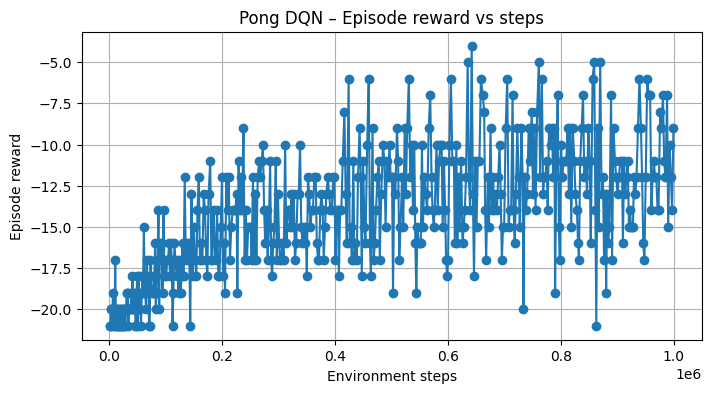

In [23]:
# episode_rewards = np.load("pong_episode_rewards.npy").tolist() - to access later
# episode_end_steps = np.load("pong_episode_end_steps.npy").tolist()


episode_rewards_arr = np.array(episode_rewards)
episode_end_steps_arr = np.array(episode_end_steps)

plt.figure(figsize=(8, 4))
plt.plot(episode_end_steps_arr, episode_rewards_arr, marker="o", linestyle="-")
plt.xlabel("Environment steps")
plt.ylabel("Episode reward")
plt.title("Pong DQN – Episode reward vs steps")
plt.grid(True)
plt.show()

### Save videos based on model checkpoints

In [ ]:
# For each model checkpoint
for step in sorted(save_model_steps):

    # Load the saved network
    
    file_name = f"pong_dqn ({step} steps)"
    try:
        print("Saving video for " + file_name)
        q_net = keras.models.load_model(f"{file_name}.keras")
    
        # Initialise the environment for rendering
        env = initialise_environment(record_video = True, video_name_prefix=file_name)
        state, info = env.reset(seed=42)
        num_actions = env.action_space.n
        
        # Record a video of the network
        record_episode(env, state, q_net)
    
        env.close()

    except ValueError:
        print("Couldn't load " + file_name)
        break